## Importing Required Packages

In [1]:
import os
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from boruta import BorutaPy
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, RFE
from sklearn.linear_model import LinearRegression, LogisticRegression
import logging
from time import time
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from operator import itemgetter


C:\Users\emplayadmin\Anaconda3\envs\py27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Importing the Data Sets + Encoding Features

In [26]:

# Importing the dataset

dataset = pd.read_csv('train.csv')

# Selection of Potential Independent Variables - Arrived at these based on EDA
dataset= dataset[['Gender','City_Category','Employer_Category1','Employer_Category2','Primary_Bank_Type','Contacted','Source','Source_Category','Approved']]
dataset= dataset.dropna()

## Encoding categorical data
dataset = dataset.apply(LabelEncoder().fit_transform)
column_names_for_onehot = dataset.columns[1:]
dataset = pd.get_dummies(dataset, columns=column_names_for_onehot, drop_first=True)


## Test/Forecast Dataset
forecast_dataset = pd.read_csv('test.csv')

# Selection of Potential Independent Variables - Arrived at these based on EDA
forecast_dataset = forecast_dataset[['Gender','City_Category','Employer_Category1','Employer_Category2','Primary_Bank_Type','Contacted','Source','Source_Category']]
forecast_dataset = forecast_dataset.dropna()

## Encoding categorical data
forecast_dataset1= forecast_dataset.apply(LabelEncoder().fit_transform)
column_names_for_onehot_forecast_dataset = forecast_dataset.columns[1:]
forecast_dataset1 = pd.get_dummies(forecast_dataset1, columns=column_names_for_onehot_forecast_dataset, drop_first=True)


## Function to find Variable Importance - Algorithmic Way of feature Selection

In [27]:

def var_selector(input_df,Y_var,problem_type = 'regression',selection_algo = 'boruta'):
    # input_df can contain only numeric columns
    if np.any([isinstance(input_df[column], str) for column in input_df]):
        logging.error('Input_df cannot contain any String values. Use one hot encoding to convert Strings to Integers.')
    if np.isfinite(input_df.values.all()) == False:
        logging.error('Input data contains Infinite values - Not allowed')
    if input_df.isnull().values.any() == True:
        logging.error('Input data contains NaN values - Not allowed')
    # retrieving a NDarray of input variables
    X = input_df.drop(Y_var,axis=1).values
    if problem_type == 'classification':
        # retrieving a NDarray of target variable
        Y = pd.factorize(input_df[Y_var])[0]
        if selection_algo == 'boruta':
            model = RandomForestClassifier(n_jobs = -1, class_weight = 'balanced_subsample', max_depth = 5, random_state = 666)
            feature_selector = BorutaPy(model, n_estimators = 'auto', verbose = 0, random_state = 666)
        elif selection_algo == 'kbest':
            feature_selector = SelectKBest(score_func = f_classif, k = X.shape[1])
        elif selection_algo == 'rfe':
            feature_selector = RFE(LogisticRegression(), 1, step = 1)
        elif selection_algo == 'rf_varimp':
            feature_selector = RandomForestClassifier(n_jobs = -1, max_depth = 5, random_state = 666)
        else:
            logging.error('Input parameter selection_algo can only take values boruta/kbest/rfe/rf_varimp')
    elif problem_type == 'regression':
        # retrieving a NDarray of target variable
        Y = input_df[Y_var].values
        if selection_algo == 'boruta':
            model = RandomForestRegressor(n_jobs = -1, max_depth = 5, random_state = 666)
            feature_selector = BorutaPy(model, n_estimators = 'auto', verbose = 0, random_state = 666)
        elif selection_algo == 'kbest':
            feature_selector = SelectKBest(score_func = f_regression, k = X.shape[1])
        elif selection_algo == 'rfe':
            feature_selector = RFE(LinearRegression(), 1, step = 1)
        elif selection_algo == 'rf_varimp':
            feature_selector = RandomForestRegressor(n_jobs = -1, max_depth = 5, random_state = 666)
        else:
            logging.error('Input parameter selection_algo can only take values boruta/kbest/rfe')
    else:
        logging.error('Input parameter problem_type can only take values regression/classification')
    # applying the variable selection algorithm on the input & taget variables
    feature_selector.fit(X,Y)
    # returning a dataframe containing variable names, importance rankings & importance scores (if available)
    if selection_algo == 'boruta' or selection_algo == 'rfe':
        if feature_selector.ranking_.min > 1:
            return pd.DataFrame({'Variable_Name':input_df.drop(Y_var,axis=1).columns,'VarImp_Rank':(feature_selector.ranking_ - 1)})
        else:
            return pd.DataFrame({'Variable_Name':input_df.drop(Y_var,axis=1).columns,'VarImp_Rank':(feature_selector.ranking_)})
    elif selection_algo == 'kbest':
        output = pd.DataFrame({'Variable_Name':input_df.drop(Y_var,axis=1).columns,'VarImp_Scores':feature_selector.scores_})
        output['VarImp_Rank'] = output['VarImp_Scores'].rank(axis=0, na_option = 'bottom',ascending = False)
    elif selection_algo == 'rf_varimp':
        output = pd.DataFrame({'Variable_Name':input_df.drop(Y_var,axis=1).columns,'VarImp_Scores':feature_selector.feature_importances_})
        output['VarImp_Rank'] = output['VarImp_Scores'].rank(axis=0, na_option = 'bottom',ascending = False)
        return output


## Determining Variable importance + Pre-Processing Steps

In [28]:
## Checking whether the Importance of any of the features is Negative or 0

var_scores = var_selector(dataset ,'Approved_1',problem_type = 'classification',selection_algo = 'rf_varimp')

## Removing the respective features from the Datasets used for Modelling purpose

feature_list = var_scores.loc[var_scores['VarImp_Scores'] > 0, 'Variable_Name'].tolist()
feature_list.append('Approved_1')

dataset = dataset[feature_list]
forecast_dataset1 = forecast_dataset1[list(set(feature_list) - set(['Approved_1']))]



# Slicing Dependent and Independent Variables 

X = dataset.loc[:,dataset.columns != 'Approved_1']
y = dataset['Approved_1']

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Dropping the missing feature values in the Test Data from the Training Dataset

missing_feature_values = list(set(list(X_train.columns)) - set(list(forecast_dataset1.columns)))
X_train.drop(missing_feature_values, axis=1, inplace=True)
X_test.drop(missing_feature_values, axis=1, inplace=True)


C:\Users\emplayadmin\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\emplayadmin\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Tuning RF Parameters

In [29]:

# calculate the time to run a GridSearchCV for multiple numbers of parameter permutations.  
grid_times = {}
clf = RandomForestClassifier(random_state = 84)

features = X_train.columns

# I commented this out after running once locally since this block of code takes a long time to run

#for number in np.arange(2, 600, 50):
#    
#    param = np.arange(1,number,10)
#    param_grid = {"n_estimators": param,
#                  "criterion": ["gini", "entropy"]}
#    
#    grid_search = GridSearchCV(clf, param_grid = param_grid)
#    
#    t0 = time()
#    grid_search.fit(X_train[features], y_train)
#    compute_time = time() - t0
#    grid_times[len(grid_search.grid_scores_)] = time() - t0
#    
#grid_times = pd.DataFrame.from_dict(grid_times, orient = 'index')

# the hardcoded values are arrived from the above commented code 
## Note: This can be skipped for Adhoc analysis 

grid_times = {0: {2: 0.5000255107879639,
 12: 26.817718029022217,
 22: 88.51770949363708,
 32: 181.1005506515503,
 42: 329.52738976478577,
 52: 478.9300322532654,
 62: 682.827840089798,
 72: 933.1604237556458,
 82: 1377.95844912529}}

Text(0.5,1,u'Time vs. Number of Parameter Permutations of GridSearchCV')

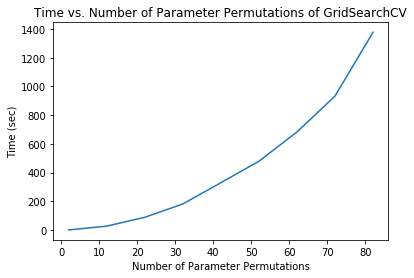

In [30]:

final = pd.DataFrame.from_dict(grid_times)
final = final.sort_index()
plt.plot(final.index.values, final[0])
plt.xlabel('Number of Parameter Permutations')
plt.ylabel('Time (sec)')
plt.title('Time vs. Number of Parameter Permutations of GridSearchCV')


C:\Users\emplayadmin\Anaconda3\envs\py27\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\emplayadmin\Anaconda3\envs\py27\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\emplayadmin\Anaconda3\envs\py27\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\emplayadmin\Anaconda3\envs\py27\lib\site-packages\sklea

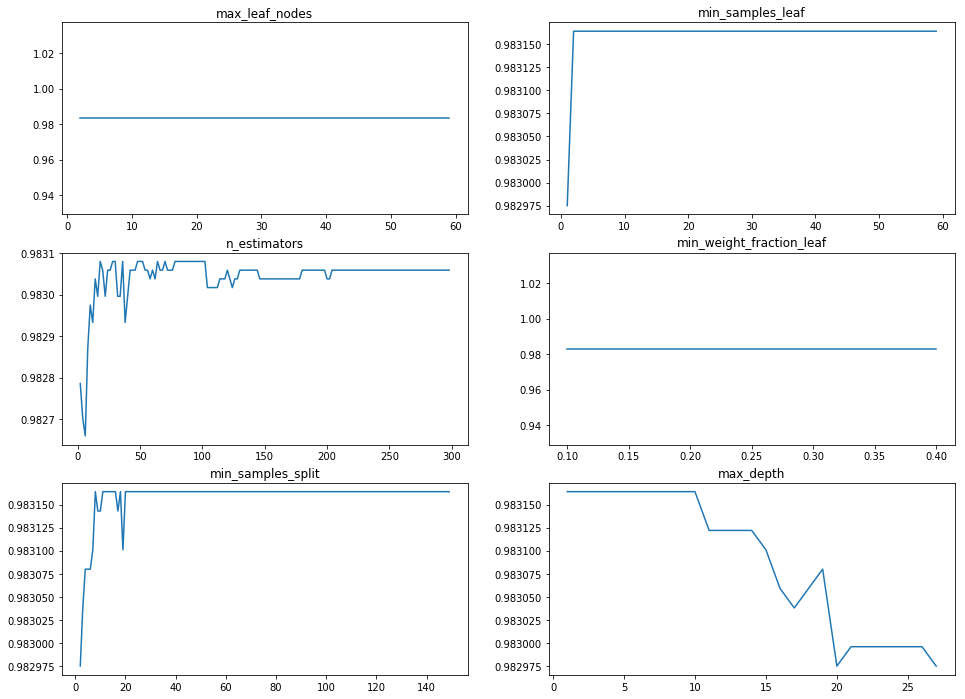

In [32]:
''' 
There are roughly 70-80 parameter Permutations. 
Looking at the superlinear rate of increase in time, we cannot practically go ahead with 100s of configurations.
From this plot, I can estimate a reasonable range for each parameter to try in GridSearchCV. 
This method will cut down on the time calculating optimum parameters. 
Of course, the downside is that the optimum parameters may still very well fall outside of these ranges. '''

''' function takes a RF parameter and a ranger and produces a plot and 
    dataframe of CV scores for parameter values '''
    
def evaluate_param(parameter, num_range, index):
    grid_search = GridSearchCV(clf, param_grid = {parameter: num_range})
    grid_search.fit(X_train[features], y_train)
    
    df = {}
    for i, score in enumerate(grid_search.grid_scores_):
        df[score[0][parameter]] = score[1]
       
    
    df = pd.DataFrame.from_dict(df, orient='index')
    df.reset_index(level=0, inplace=True)
    df = df.sort_values(by='index')
 
    plt.subplot(3,2,index)
    plot = plt.plot(df['index'], df[0])
    plt.title(parameter)
    return plot, df

# parameters and ranges to plot
param_grid = {"n_estimators": np.arange(2, 300, 2),
              "max_depth": np.arange(1, 28, 1),
              "min_samples_split": np.arange(2,150,1),
              "min_samples_leaf": np.arange(1,60,1),
              "max_leaf_nodes": np.arange(2,60,1),
              "min_weight_fraction_leaf": np.arange(0.1,0.4, 0.1)}

index = 1
plt.figure(figsize=(16,12))
for parameter, param_range in dict.items(param_grid):   
    evaluate_param(parameter, param_range, index)
    index += 1
    


In [35]:

'''
I can narrow the parameters for GridSearchCV using the plots above. 
For example, 2 to 10 max_leaf_nodes has been giving better performance which decreases later.
Therefore I will restrict my GridSearchCV to the range [5,8]. 
This helps restrict the number of permutations I need to run. '''

# Utility function to report best scores
def report(grid_scores, n_top):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.4f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

# parameters for GridSearchCV
param_grid2 = {"n_estimators": [85,95],
              "max_depth": [4,8],
              "min_samples_split": [25, 35],
              "min_samples_leaf": [10, 20],
              "max_leaf_nodes": [20, 40],
              "min_weight_fraction_leaf": [0.2]}

grid_search = GridSearchCV(clf, param_grid=param_grid2)
grid_search.fit(X_train[features], y_train)

report(grid_search.grid_scores_, 4)


Model with rank: 1
Mean validation score: 0.9832)
Parameters: {'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'n_estimators': 85, 'min_weight_fraction_leaf': 0.2, 'min_samples_split': 25, 'max_depth': 4}

Model with rank: 2
Mean validation score: 0.9832)
Parameters: {'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'n_estimators': 95, 'min_weight_fraction_leaf': 0.2, 'min_samples_split': 25, 'max_depth': 4}

Model with rank: 3
Mean validation score: 0.9832)
Parameters: {'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'n_estimators': 85, 'min_weight_fraction_leaf': 0.2, 'min_samples_split': 35, 'max_depth': 4}

Model with rank: 4
Mean validation score: 0.9832)
Parameters: {'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'n_estimators': 95, 'min_weight_fraction_leaf': 0.2, 'min_samples_split': 35, 'max_depth': 4}



C:\Users\emplayadmin\Anaconda3\envs\py27\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


## Building the Final Classifier

In [56]:
classifier = RandomForestClassifier(max_depth = 4, 
                                    max_leaf_nodes= 20, 
                                    min_samples_leaf = 10,
                                    min_samples_split = 25,
                                    min_weight_fraction_leaf = 0.2, 
                                    n_estimators = 95)
classifier.fit(X_train, y_train)


# Checking Model Accuracy
model_accuracy = classifier.score(X_test, y_test)
print("Model Accuracy :" + str(round(model_accuracy*100,2))+"%")

Model Accuracy :98.41%


## Finding Probability

In [64]:
## Finding Probability 
probability_train = pd.DataFrame(classifier.predict_proba(X_test))
probability_train.columns = ['Not Approved','Approved']


'''
Since the Average conversion affected by all the individual predictors is 1.46% (Arrived from EDA),
I am using it as a cut-off to arrive at High Probability Leads from the given dataset (Relative Probability Method)
This cutoff can be further tuned based on the future performance of the model '''

high_prob_leads_train = probability_train.loc[probability_train['Approved']>0.0146,:]


## Finding Probability for Test (Forecasting Lead Probability)
probability_test = pd.DataFrame(classifier.predict_proba(forecast_dataset1))
probability_test.columns = ['Not Approved','Approved']

high_prob_leads_forecast = probability_test.loc[probability_test['Approved']>0.0146,:]

forecast_results = pd.concat([probability_test,forecast_dataset], axis = 1)


In [66]:
high_prob_leads_forecast.head()

,Not Approved,Approved
26,0.985393,0.014607
70,0.985393,0.014607
101,0.985393,0.014607
104,0.985393,0.014607
141,0.985393,0.014607
